In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

In [2]:
# read the files
user = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Funnel Analysis\\user_table.csv")
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [3]:
home_page = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\Funnel Analysis\\home_page_table.csv")
home_page.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [4]:
search_page = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Funnel Analysis\\search_page_table.csv")
search_page.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [5]:
payment_page = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Funnel Analysis\\payment_page_table.csv")
payment_page.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [6]:
payment_confirmation = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Funnel Analysis\\payment_confirmation_table.csv")
payment_confirmation.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


### Data Analysis

In [7]:
# merge all the files by using user_id
data=pd.merge(user,home_page,how='left',on='user_id')
data=pd.merge(data,search_page,how='left',on='user_id',suffixes=('_home','_search'))
data=pd.merge(data,payment_page,how='left',on='user_id')
data=pd.merge(data,payment_confirmation,how='left',on='user_id',suffixes=('_payment','_confirmation'))
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [8]:
#Replace NAs with 0 and non-NAs with 1
for i in range(4,8):
    data.iloc[:,i] = np.where(data.iloc[:,i].isna(), 0, 1)

In [9]:
# Make the date column in datetime format
data['date'] = pd.to_datetime(data['date'])

In [10]:
# Check the data statistics
data.describe()

,user_id,page_home,page_search,page_payment,page_confirmation
count,90400.000000,90400.0,90400.000000,90400.000000,90400.000000
mean,498709.683473,1.0,0.500000,0.066704,0.005000
std,289040.674085,0.0,0.500003,0.249509,0.070534
min,17.000000,1.0,0.000000,0.000000,0.000000
25%,247978.750000,1.0,0.000000,0.000000,0.000000
50%,498267.000000,1.0,0.500000,0.000000,0.000000
75%,749789.250000,1.0,1.000000,0.000000,0.000000
max,999979.000000,1.0,1.000000,1.000000,1.000000


In [11]:
# Check if user_id is unique
data['user_id'].nunique()==len(data)

True

In [12]:
# Check if anyone who made it to a given step of the funnel also made it to the prior step(s). Unique number of the prior steps has to be larger than the current step
(data['page_search'] >= data['page_payment']).unique()

array([ True])

In [13]:
(data['page_payment'] >= data['page_confirmation']).unique()

array([ True])

### Funnel Converion Rate

In [14]:
# Overall conversion rate for desktop and mobile
data.groupby('device')['page_confirmation'].agg({'mean', 'count'})

,count,mean
device,,
Desktop,60200,0.002492
Mobile,30200,0.010000


#### Insights
- Overall mobile conversion rate is 4 times higher than desktop
- Desktop has 2 times more page - confirmed users than mobile
- Conversion is significantly lower than 1% which is pretty low for most online business

In [15]:
# Check the conversion rate for the entire funnel
data.groupby('device').apply(
                    lambda x: pd.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  }))

,to_search,to_payment,to_confirmation
device,,,
Desktop,0.5,0.1,0.049834
Mobile,0.5,0.2,0.100000


#### Insights
- 50% bouncers are pretty common
- to payment and to confirmation percentage is very low
- We can safely assume that people who made it to the search page have some intent to buy. However, only 1% of these people convert on desktop and 2% of mobile! 

### Time-Series Analysis

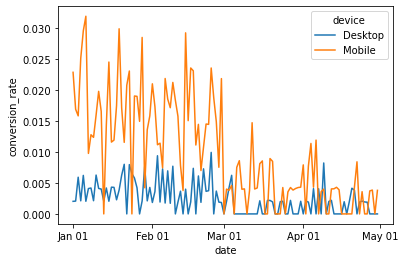

In [16]:
# conversion rate as a time series
cr_ts = data.groupby(['date', 'device'])['page_confirmation'].mean().reset_index(name='conversion_rate')
  
g = sns.lineplot(x="date", hue="device", y="conversion_rate", data=cr_ts)  

g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

#### Insights
- Both desktop and mobile dropped significantly at the beginning of March

In [18]:
# Break down the funnel into its page-by-page steps to see if those drops are related to a given page
funnel = data.groupby(['date', 'device']).apply(
                    lambda x: pd.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  })).reset_index()

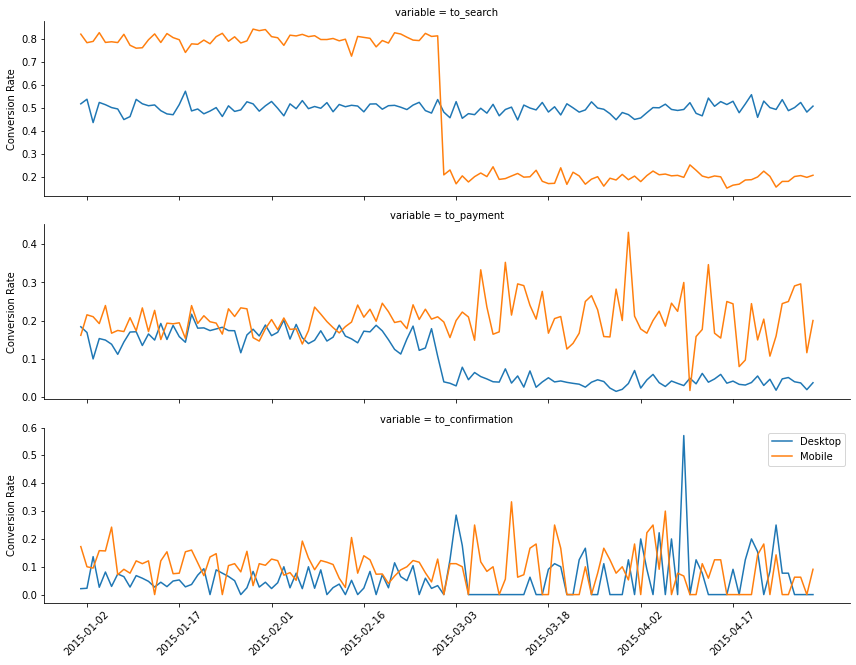

In [19]:
#Make the dataset long for the plot
funnel = pd.melt(funnel,id_vars=['date', 'device'])
#Plot it
g = sns.FacetGrid(funnel, hue="device", row="variable", aspect=4, sharey=False)
g.map(sns.lineplot, "date", "value")

g.set_axis_labels("", "Conversion Rate")
g.set(xticks=funnel.date[2::30].unique())
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

#### Insights
- Both desktop and dropped on March, but this happened on different pages
- Mobile had a huge drop during the to_search step
- Desktop had a huge drop on the to_payment step

### Product Insights

In [20]:
# Overall conversion rate by gender
data.groupby('sex')['page_confirmation'].agg({'mean', 'count'})

,count,mean
sex,,
Female,45075,0.005347
Male,45325,0.004655


#### Insights
- We almost have the same number of Male and Female users
- Conversion rate appears pretty similar too

In [24]:
# We want to check if the small difference in conversion rate is statistically significant
from scipy import stats
# Run statistical test on conversion rate and gender
test = stats.ttest_ind(data.loc[data['sex'] == 'Female']['page_confirmation'], data.loc[data['sex'] != 'Female']['page_confirmation'], equal_var=False)
  
#t statistics
print(test.statistic)

1.473291657657286


In [22]:
#p-value
print(test.pvalue)

0.14067591026227633


In [25]:
# the result is not significant. Overall, gender does not affect the conversion in a statistically significant way. 

In [26]:
#interaction of sex and device
print(data.groupby(['device', 'sex'])['page_confirmation'].agg({'mean', 'count'}))

                count      mean
device  sex                    
Desktop Female  29997  0.002467
        Male    30203  0.002516
Mobile  Female  15078  0.011076
        Male    15122  0.008927


#### Insights
It looks like the entire difference in conversion rate between males and females comes from mobile. Hard to say more without having more variables. It could very well be noise, or a proxy for some other variables. In any case, this is something that might lead to further analysis, although it is certainly not a top priority given everything else we discovered.


### Conclusions

- Desktop has way more users than mobile, but with much lower conversion rate. Having less mobile visitors is pretty worrisome. Pretty much all healthy tech companies should have more mobile users than desktop. So growing mobile should be a top priority for the company as a whole
- There are a couple of ways to explain the lower conversion rate on desktop:
    - Product: desktop has a worse product. So product team should look into the differences between the two to see if UX/UI can be improved on desktop

    - Marketing: the two platforms are attracting different kinds of users. So they just act as a proxy for user distribution. For instance, mobile didn’t get popular and only has power users, who obviously convert at a much higher rate. Or desktop is spending a lot on ads and these ads are attracting lower intent users. If we had more data about the users, we could find out if user distribution is the same across the devices (so it is most likely a product problem) or not (-> marketing problem). The marketing explanation has the advantage of explaining also the strangely lower absolute count for mobile users
- All key metrics for both devices have actually gone down a lot in the last few months. All drops though appear to happen on specific days and one specific page. This kind of behavior is often the sign of a bug (more likely) or bad product changes (which at the end of the day are basically bugs too, just product bugs instead of engineering bugs). Usual analysis steps to find out why a metric suddenly dropped should be done here.
- It is hard to say without more information about the site, but the funnel numbers across the board don’t look particularly good. For instance, even before the bug, only at most 20% of users go from the search page to the payment page. These are clearly users with some sort of intent. It could be interesting to look into the characteristics of the search queries to see if people are constantly looking for something they cannot find. Essentially, trying to understand lack of supply compared to user demand.